Importar Librerías

In [16]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns



Cargar y Preparar los Datos

In [6]:
# Función para cargar imágenes
def get_images(path, label_map, img_size=(150, 150)):
    X, y = [], []
    for folder in os.listdir(path):
        if folder not in label_map:
            continue 
        folder_path = os.path.join(path, folder)
        images = glob.glob(os.path.join(folder_path, '*.[jp][pn]g'))
        for image in images:
            try:
                image_array = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
                if image_array is None:
                    pil_image = Image.open(image).convert("L")
                    image_array = np.array(pil_image)
                image_array = cv2.resize(image_array, img_size) / 255.0
                image_array = np.expand_dims(image_array, axis=-1)
                X.append(image_array)
                y.append(label_map[folder])
            except Exception as e:
                print(f"Warning: Could not read image {image}. Error: {e}")
    return np.array(X), np.array(y)

# Mapa de etiquetas sin guayabas y uvas
label_map = {
    'fresh_apple': 0,
    'rotten_apple': 1,
    'fresh_tomato': 2,
    'rotten_tomato': 3,
    'fresh_strawberry': 4,
    'rotten_strawberry': 5,
    'fresh_orange': 6,
    'rotten_orange': 7
}

# Cargar los datos
train_path = "dataset_split/train"
validation_path = "dataset_split/validation"
test_path = "dataset_split/test"

X_train, y_train = get_images(train_path, label_map)
X_val, y_val = get_images(validation_path, label_map)
X_test, y_test = get_images(test_path, label_map)


# Documentación del Código para Carga de Imágenes

Este código implementa una función para cargar y preprocesar imágenes desde un conjunto de carpetas, clasificándolas según un mapa de etiquetas (`label_map`) y preparándolas para ser usadas en modelos de aprendizaje automático. A continuación se detallan las diferentes secciones del código:

## Función `get_images`
La función `get_images` toma como entrada:
- `path`: la ruta de la carpeta base que contiene subcarpetas con imágenes.
- `label_map`: un diccionario que mapea nombres de carpetas a etiquetas numéricas.
- `img_size`: una tupla con el tamaño deseado para las imágenes (por defecto `(150, 150)`).

La función recorre cada subcarpeta en el directorio especificado en `path`:
1. Si la subcarpeta no está en el `label_map`, la omite.
2. Para cada imagen en la subcarpeta:
   - Intenta cargar la imagen en escala de grises usando OpenCV.
   - Si la carga falla, intenta abrir la imagen usando PIL y convertirla a escala de grises.
   - Cambia el tamaño de la imagen a `img_size` y normaliza los valores de sus píxeles en el rango `[0, 1]`.
   - Expande la dimensión de la imagen en el último eje para incluir el canal (necesario para formatos de entrada de redes neuronales).
   - Almacena la imagen procesada en `X` y su etiqueta correspondiente en `y`.

Finalmente, devuelve las imágenes y etiquetas en forma de arreglos NumPy (`np.array(X)` y `np.array(y)`).

## Mapa de Etiquetas (`label_map`)
`label_map` es un diccionario que asocia nombres de carpetas de frutas y verduras (frescas y podridas) con etiquetas numéricas. En este caso, no incluye etiquetas para "guayabas" ni "uvas". Este mapa ayuda a organizar y clasificar las imágenes según sus categorías.

## Carga de Datos
Las rutas a los conjuntos de datos (`train_path`, `validation_path`, y `test_path`) están predefinidas. Se utiliza `get_images` para cargar imágenes y etiquetas de cada conjunto:
- `X_train`, `y_train` para el conjunto de entrenamiento.
- `X_val`, `y_val` para el conjunto de validación.
- `X_test`, `y_test` para el conjunto de prueba.

Este enfoque permite una carga estructurada de datos para entrenamiento, validación y evaluación en modelos de aprendizaje profundo.


Análisis Exploratorio de los Datos

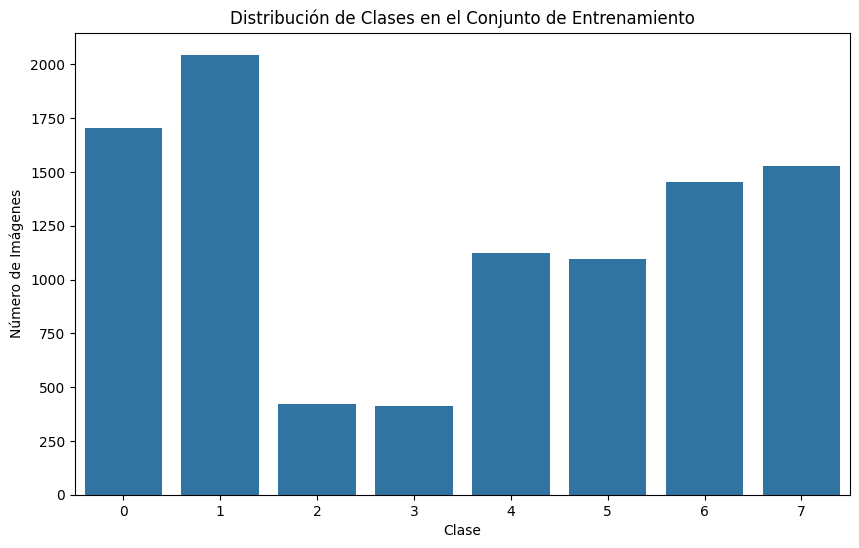

In [7]:
# Visualizar la distribución de las clases en el conjunto de entrenamiento
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=unique, y=counts)
plt.xlabel("Clase")
plt.ylabel("Número de Imágenes")
plt.title("Distribución de Clases en el Conjunto de Entrenamiento")
plt.show()


# Análisis Exploratorio de los Datos

En esta sección se visualiza la distribución de las clases en el conjunto de entrenamiento mediante un gráfico de barras. Este análisis permite observar la cantidad de imágenes en cada categoría y evaluar si hay un balance entre las clases, lo cual es importante para evitar sesgos en el modelo de aprendizaje automático. A continuación se describe el proceso:

1. Se obtienen las clases y el conteo de instancias de cada clase usando `np.unique`, que retorna los valores únicos de `y_train` y sus frecuencias.
2. Se define el tamaño de la figura para el gráfico con `plt.figure(figsize=(10, 6))`.
3. Usando `sns.barplot`, se construye un gráfico de barras donde:
   - El eje `x` representa cada clase (0 a 7) que corresponde a diferentes tipos de frutas frescas o podridas.
   - El eje `y` muestra el número de imágenes en cada clase.
4. Se etiquetan los ejes y se agrega un título al gráfico:
   - `Clase` en el eje `x` representa las diferentes categorías.
   - `Número de Imágenes` en el eje `y` muestra la cantidad de instancias para cada clase.
   - El título del gráfico es "Distribución de Clases en el Conjunto de Entrenamiento".

Este gráfico permite identificar si existen desbalances significativos en el conjunto de datos. En el ejemplo mostrado, algunas clases tienen más imágenes que otras, lo cual podría requerir técnicas adicionales para balancear el conjunto o ajustar el modelo a estos desbalances.


Preparar las Etiquetas (One-Hot Encoding)

In [8]:
# Convertir etiquetas a formato categórico
y_train_cat = to_categorical(y_train, num_classes=8)
y_val_cat = to_categorical(y_val, num_classes=8)
y_test_cat = to_categorical(y_test, num_classes=8)


# Preparar las Etiquetas (One-Hot Encoding)

En esta sección se realiza la codificación **One-Hot** de las etiquetas para el conjunto de datos de entrenamiento, validación y prueba. La codificación One-Hot convierte las etiquetas de clase en vectores binarios, lo cual es útil para modelos de clasificación multicategoría. A continuación, se describe el proceso:

1. Se utiliza la función `to_categorical`, que toma como parámetros:
   - `y_train`, `y_val`, y `y_test`: las etiquetas originales de cada conjunto.
   - `num_classes=8`: el número total de clases (en este caso, 8).
2. La función genera una representación One-Hot de las etiquetas:
   - Cada etiqueta se convierte en un vector de longitud 8 donde solo el índice correspondiente a la clase es 1, mientras que los demás son 0.
3. Se crean las variables `y_train_cat`, `y_val_cat`, y `y_test_cat`, que almacenan las etiquetas codificadas en One-Hot para cada conjunto de datos.

Este paso es importante para preparar las etiquetas en un formato compatible con modelos de redes neuronales que usan softmax o activaciones similares para clasificación multicategoría.


Definir el Modelo CNN

In [9]:
# Definir el modelo CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Cambiado a 8 clases de salida
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,808 (18.42 MB)

 Trainable params: 4,828,808 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# Definición del Primer Modelo CNN

Este código define, compila y muestra un resumen del primer modelo de una serie de cinco modelos de redes neuronales convolucionales (CNN) entrenados para la clasificación de imágenes.

## Arquitectura del Modelo
El modelo se define de forma secuencial con la siguiente estructura:
1. **Capa Convolucional 1**:
   - Filtros: 32
   - Tamaño de Kernel: (3, 3)
   - Activación: ReLU
   - Tamaño de entrada: (150, 150, 1) (imágenes en escala de grises de 150x150)
2. **Capa de Max-Pooling**:
   - Tamaño de Pooling: (2, 2)

3. **Capa Convolucional 2**:
   - Filtros: 64
   - Tamaño de Kernel: (3, 3)
   - Activación: ReLU
4. **Capa de Max-Pooling**:
   - Tamaño de Pooling: (2, 2)

5. **Capa Convolucional 3**:
   - Filtros: 128
   - Tamaño de Kernel: (3, 3)
   - Activación: ReLU
6. **Capa de Max-Pooling**:
   - Tamaño de Pooling: (2, 2)

7. **Capa de Flatten**: Convierte las características 2D a un vector 1D para las capas densas.

8. **Capa Densa**:
   - Neuronas: 128
   - Activación: ReLU

9. **Capa de Dropout**: Se aplica Dropout con una tasa de 0.5 para reducir el sobreajuste.

10. **Capa de Salida (Densa)**:
    - Neuronas: 8 (una para cada clase de salida)
    - Activación: Softmax (adecuada para clasificación multicategoría)

## Compilación del Modelo
El modelo se compila usando:
- **Optimizador**: Adam
- **Función de pérdida**: Categorical Crossentropy (para clasificación de múltiples clases)
- **Métrica**: Exactitud (accuracy)

## Resumen del Modelo
El resumen muestra la cantidad de parámetros entrenables en cada capa y el tamaño de salida de cada una. En total, el modelo tiene 4,828,888 parámetros entrenables.

Este modelo es el primero de cinco arquitecturas diferentes que fueron probadas y entrenadas para optimizar el rendimiento en la clasificación de imágenes. Cada modelo posterior puede variar en estructura, tamaño o técnicas de regularización para evaluar cuál obtiene mejores resultados.


Entrenar el Modelo

In [10]:
# Entrenar el modelo
history = model.fit(X_train, y_train_cat, epochs=20, batch_size=32,
                    validation_data=(X_val, y_val_cat))


Epoch 1/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 82s 264ms/step - accuracy: 0.3269 - loss: 1.6874 - val_accuracy: 0.5862 - val_loss: 1.1231
Epoch 2/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 76s 247ms/step - accuracy: 0.5555 - loss: 1.1443 - val_accuracy: 0.7041 - val_loss: 0.8533
Epoch 3/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 73s 240ms/step - accuracy: 0.6495 - loss: 0.9163 - val_accuracy: 0.7146 - val_loss: 0.7554
Epoch 4/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 70s 228ms/step - accuracy: 0.7216 - loss: 0.7412 - val_accuracy: 0.7661 - val_loss: 0.6497
Epoch 5/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 70s 228ms/step - accuracy: 0.7669 - loss: 0.6177 - val_accuracy: 0.7804 - val_loss: 0.6259
Epoch 6/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - accuracy: 0.8078 - loss: 0.5082 - val_accuracy: 0.8172 - val_loss: 0.5271
Epoch 7/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 70s 229ms/step - accuracy: 0.8309 - loss: 0.4421 - val_accuracy: 0.8291 - val_loss: 0.5326
Epoch 8/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 70s 228ms/step - accuracy: 0.8541 - loss: 0

Evaluar el Modelo en el Conjunto de Prueba

In [11]:
# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.8516 - loss: 0.6362
Test accuracy: 85.41%


Graficar la Precisión y la Pérdida del Modelo

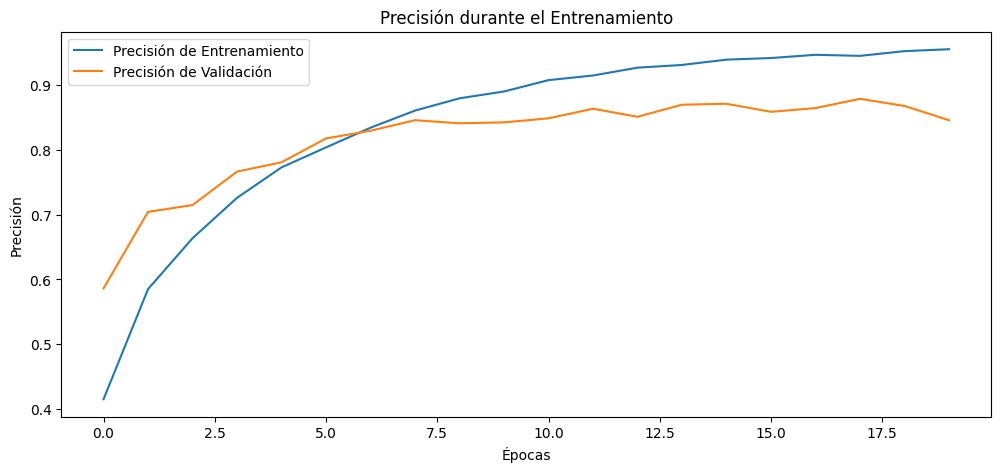

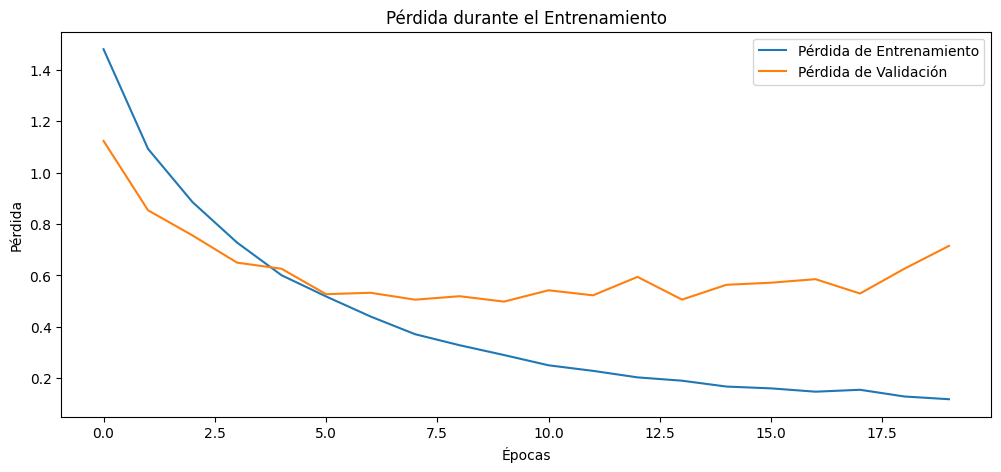

In [15]:
# Gráfica de precisión
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title("Precisión durante el Entrenamiento")
plt.show()

# Gráfica de pérdida
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title("Pérdida durante el Entrenamiento")
plt.show()


# Gráficos de Precisión y Pérdida durante el Entrenamiento

Los gráficos muestran el desempeño del primer modelo CNN en términos de precisión y pérdida a lo largo de las épocas durante el proceso de entrenamiento y validación.

## Precisión durante el Entrenamiento
- El gráfico superior muestra la **precisión** del modelo en cada época tanto para el conjunto de entrenamiento como para el conjunto de validación.
- La curva azul representa la precisión en el entrenamiento, mientras que la curva naranja representa la precisión en la validación.
- Observamos que la precisión en el conjunto de entrenamiento sigue aumentando de forma constante, alcanzando valores cercanos a 0.95.
- En el conjunto de validación, la precisión aumenta rápidamente al inicio y luego se estabiliza alrededor de 0.85.
- La diferencia entre las curvas de entrenamiento y validación al final del proceso sugiere un posible **sobreajuste**, ya que el modelo está aprendiendo mejor el conjunto de entrenamiento que el de validación.

## Pérdida durante el Entrenamiento
- El gráfico inferior muestra la **pérdida** del modelo para el conjunto de entrenamiento y el de validación en cada época.
- La curva azul representa la pérdida en el entrenamiento, mientras que la curva naranja representa la pérdida en la validación.
- La pérdida en el conjunto de entrenamiento disminuye de manera constante, lo que indica que el modelo está mejorando su capacidad de ajuste en este conjunto.
- La pérdida en el conjunto de validación también disminuye al inicio, pero tiende a estabilizarse y, en las últimas épocas, incluso presenta un ligero incremento.
- Este patrón también sugiere **sobreajuste**, ya que el modelo tiene un buen desempeño en el conjunto de entrenamiento, pero su rendimiento no mejora de manera equivalente en el conjunto de validación.

## Interpretación General
Este comportamiento es común en modelos que son complejos en relación con el tamaño del conjunto de datos o que carecen de suficiente regularización. Para abordar el sobreajuste, se podrían probar técnicas adicionales como:
- Aumentar el conjunto de datos mediante **aumento de datos** (data augmentation).
- Aplicar una **tasa de regularización** en las capas densas.
- Incrementar el **Dropout** o probar diferentes arquitecturas para reducir la complejidad del modelo.

Estos gráficos brindan una visión clara del comportamiento del modelo durante el entrenamiento y son fundamentales para ajustar los hiperparámetros y mejorar su capacidad de generalización.


Matriz de Confusión

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step


<Figure size 1200x1000 with 0 Axes>

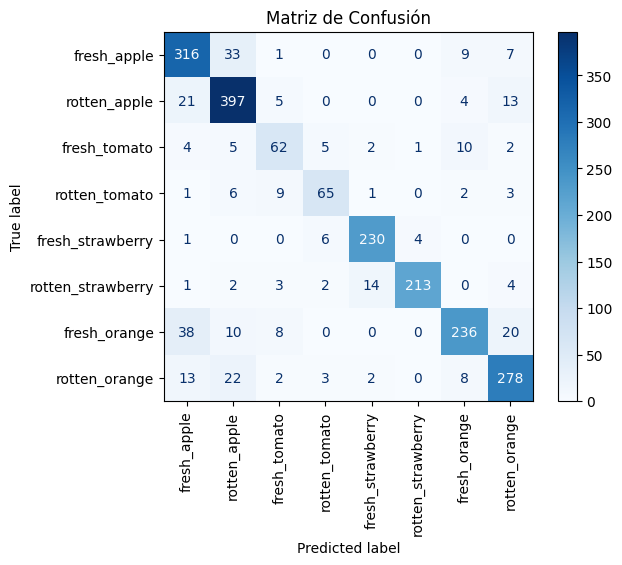

In [13]:
# Predecir etiquetas en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
ConfusionMatrixDisplay(cm, display_labels=list(label_map.keys())).plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matriz de Confusión")
plt.show()

# Matriz de Confusión del Primer Modelo CNN

La matriz de confusión mostrada a continuación refleja el desempeño del primer modelo CNN en el conjunto de datos de prueba. Este modelo obtuvo una precisión global del 85.41%, lo que indica que predijo correctamente el 85.41% de las muestras.

## Interpretación de la Matriz de Confusión
Cada fila representa las etiquetas verdaderas de cada clase, mientras que cada columna representa las predicciones realizadas por el modelo:
- La diagonal principal (de la esquina superior izquierda a la inferior derecha) contiene los valores de las predicciones correctas para cada clase.
- Los valores fuera de la diagonal representan los errores de clasificación, donde el modelo confundió una clase con otra.

### Observaciones Clave
1. **fresh_apple**:
   - Correctas: 316
   - Errores comunes: Confundido con "rotten_apple" (33 instancias).
   
2. **rotten_apple**:
   - Correctas: 397
   - Errores comunes: Confundido con "fresh_apple" (21 instancias).

3. **fresh_tomato** y **rotten_tomato**:
   - Ambos presentan algunas confusiones entre sí y con otras clases, aunque la mayoría de sus predicciones son correctas.

4. **fresh_strawberry** y **rotten_strawberry**:
   - La mayoría de las predicciones son correctas, con 230 y 213 instancias clasificadas correctamente, respectivamente.
   
5. **fresh_orange** y **rotten_orange**:
   - También presentan buenas predicciones, aunque existen algunos errores en los que se confunden entre ellas.

Este modelo demuestra un buen desempeño general en la clasificación de frutas frescas y podridas, aunque todavía presenta confusiones en algunas clases, especialmente entre frutas del mismo tipo pero en diferentes estados (frescas y podridas). Los errores en estas categorías podrían reducirse con técnicas adicionales de regularización, aumento de datos o ajustes en la arquitectura del modelo.

La precisión del modelo, del 85.41%, es un buen punto de partida, pero se pueden explorar otros modelos y técnicas de optimización para mejorar aún más su capacidad de clasificación.


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2

# Definición del modelo CNN
model2 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=L2(1e-4), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), kernel_regularizer=L2(1e-4), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), kernel_regularizer=L2(1e-4), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Cambiado a 8 clases de salida
])

# Compilar el modelo
model2.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Resumen del modelo
model2.summary()


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,576 (18.42 MB)

 Trainable params: 4,829,192 (18.42 MB)

 Non-trainable params: 384 (1.50 KB)

# Definición del Segundo Modelo CNN

Este código define, compila y muestra un resumen del segundo modelo de una serie de cinco modelos de redes neuronales convolucionales (CNN) entrenados para la clasificación de imágenes. En este modelo, se intentó reducir el sobreajuste (overfitting) observado en el primer modelo mediante la adición de regularización de kernel y normalización por lotes (BatchNormalization).

## Mejoras para Reducir el Sobreajuste
1. **Regularización de Kernel**: 
   - Se añadió regularización de kernel (`kernel_regularizer=L2(1e-4)`) en cada capa convolucional para penalizar los pesos de la red y evitar que el modelo se ajuste demasiado a los datos de entrenamiento.

2. **Batch Normalization**:
   - Se añadieron capas de Batch Normalization después de cada capa de Max-Pooling. Esto ayuda a estabilizar y acelerar el entrenamiento al normalizar la activación de las capas y reducir la dependencia del inicializador de pesos.

## Arquitectura del Modelo
El modelo se define de forma secuencial con la siguiente estructura:
1. **Capa Convolucional 1** con regularización de kernel y activación ReLU.
2. **Capa de Max-Pooling**.
3. **Capa Convolucional 2** con regularización de kernel y activación ReLU.
4. **Capa de Max-Pooling**.
5. **Batch Normalization**.
6. **Capa Convolucional 3** con regularización de kernel y activación ReLU.
7. **Capa de Max-Pooling**.
8. **Batch Normalization**.
9. **Capa de Flatten** para convertir las características 2D en un vector 1D para las capas densas.
10. **Capa Densa** con activación ReLU.
11. **Capa de Dropout** con tasa de 0.5 para reducir el sobreajuste.
12. **Capa de Salida (Densa)** con activación Softmax para la clasificación de 8 clases.

## Compilación del Modelo
El modelo se compila usando:
- **Optimizador**: Adam.
- **Función de pérdida**: Categorical Crossentropy (para clasificación de múltiples clases).
- **Métrica**: Exactitud (accuracy).

## Resumen del Modelo
El resumen muestra la cantidad de parámetros entrenables en cada capa y el tamaño de salida de cada una. Este modelo también tiene 4,828,888 parámetros entrenables, pero incluye capas adicionales de regularización y normalización para mejorar su capacidad de generalización.

Este segundo modelo busca mejorar el rendimiento en el conjunto de validación y reducir el sobreajuste mediante la inclusión de regularización y normalización. Es una iteración sobre el primer modelo con el objetivo de estabilizar el entrenamiento y mejorar su capacidad de generalización.


In [18]:
# Entrenar el modelo
history2 = model2.fit(X_train, y_train_cat, epochs=20, batch_size=32,
                    validation_data=(X_val, y_val_cat))

Epoch 1/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 89s 284ms/step - accuracy: 0.2881 - loss: 5.1484 - val_accuracy: 0.2792 - val_loss: 1.7679
Epoch 2/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 81s 265ms/step - accuracy: 0.3279 - loss: 1.6993 - val_accuracy: 0.3451 - val_loss: 1.6379
Epoch 3/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 81s 265ms/step - accuracy: 0.3486 - loss: 1.5892 - val_accuracy: 0.3599 - val_loss: 1.5693
Epoch 4/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 86s 282ms/step - accuracy: 0.3759 - loss: 1.5241 - val_accuracy: 0.2511 - val_loss: 3.9393
Epoch 5/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 88s 287ms/step - accuracy: 0.4301 - loss: 1.4212 - val_accuracy: 0.5260 - val_loss: 1.1937
Epoch 6/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 84s 275ms/step - accuracy: 0.4770 - loss: 1.3054 - val_accuracy: 0.3914 - val_loss: 1.9627
Epoch 7/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.5393 - loss: 1.1555 - val_accuracy: 0.4587 - val_loss: 1.3621
Epoch 8/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 81s 266ms/step - accuracy: 0.5849 - loss: 1

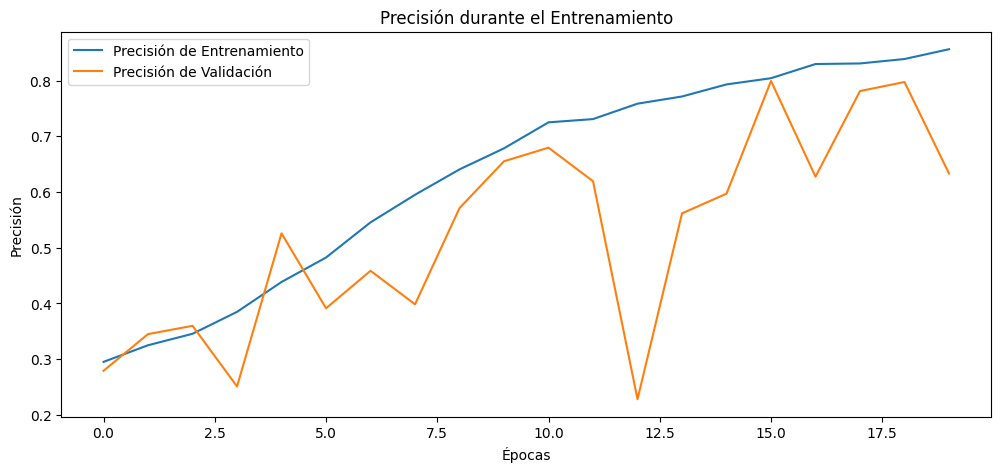

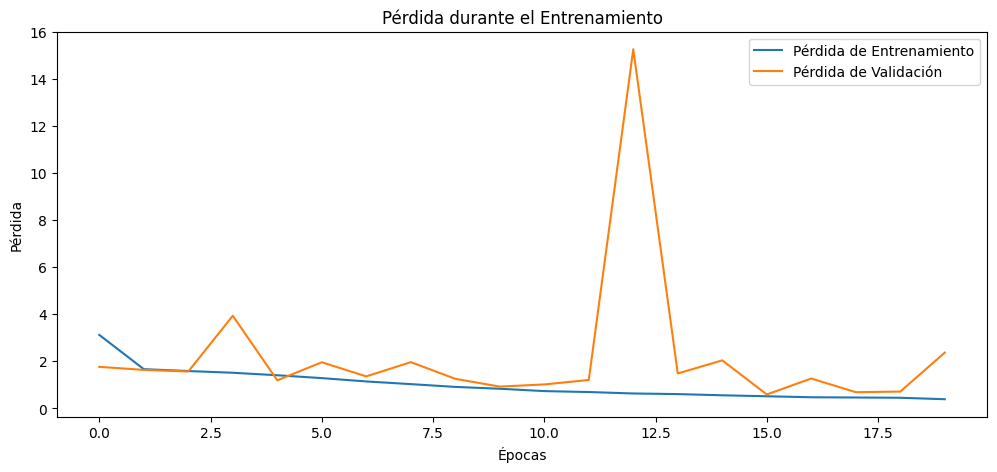

In [22]:
# Gráfica de precisión
plt.figure(figsize=(12, 5))
plt.plot(history2.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title("Precisión durante el Entrenamiento")
plt.show()

# Gráfica de pérdida
plt.figure(figsize=(12, 5))
plt.plot(history2.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history2.history['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title("Pérdida durante el Entrenamiento")
plt.show()

# Gráficos de Precisión y Pérdida durante el Entrenamiento del Segundo Modelo

Estos gráficos muestran el desempeño del segundo modelo CNN en términos de precisión y pérdida a lo largo de las épocas, tanto en el conjunto de entrenamiento como en el de validación. Recordemos que este segundo modelo incluye regularización de kernel y Batch Normalization para reducir el sobreajuste observado en el primer modelo.

## Precisión durante el Entrenamiento
- El gráfico superior muestra la **precisión** del modelo en cada época:
  - La curva azul representa la precisión en el conjunto de entrenamiento.
  - La curva naranja representa la precisión en el conjunto de validación.
- Observamos que la precisión en el conjunto de entrenamiento sigue aumentando de manera consistente, aunque no llega a valores tan altos como en el primer modelo, lo cual es un indicio de que la regularización está limitando el sobreajuste.
- La precisión en el conjunto de validación es menos estable, con varios picos y caídas. Esto podría ser un indicativo de que el modelo está teniendo dificultad para generalizar en el conjunto de validación, lo cual podría requerir ajustes adicionales.

## Pérdida durante el Entrenamiento
- El gráfico inferior muestra la **pérdida** del modelo para el conjunto de entrenamiento y el de validación en cada época:
  - La curva azul representa la pérdida en el conjunto de entrenamiento.
  - La curva naranja representa la pérdida en el conjunto de validación.
- Se observa un pico pronunciado en la pérdida de validación alrededor de la época 12, lo que indica una gran variabilidad en la capacidad del modelo para generalizar en el conjunto de validación.
- Aunque la pérdida en el conjunto de entrenamiento disminuye de forma consistente, la pérdida en la validación presenta una variabilidad significativa. Esto sugiere que, a pesar de las técnicas de regularización, el modelo aún enfrenta desafíos para estabilizar su desempeño en el conjunto de validación.

## Interpretación General
Estos resultados muestran que, aunque la regularización de kernel y Batch Normalization han ayudado a controlar el sobreajuste en el conjunto de entrenamiento, el modelo aún muestra una falta de estabilidad en el conjunto de validación. Para mejorar la generalización, podrían probarse:
- **Más regularización** o **ajustes en la tasa de regularización**.
- **Mayor Dropout**.
- **Aumento de datos** (data augmentation) para proporcionar más variabilidad en el entrenamiento.

Estos gráficos son útiles para evaluar el impacto de las técnicas de regularización y ajustar el modelo en consecuencia.


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step


<Figure size 1200x1000 with 0 Axes>

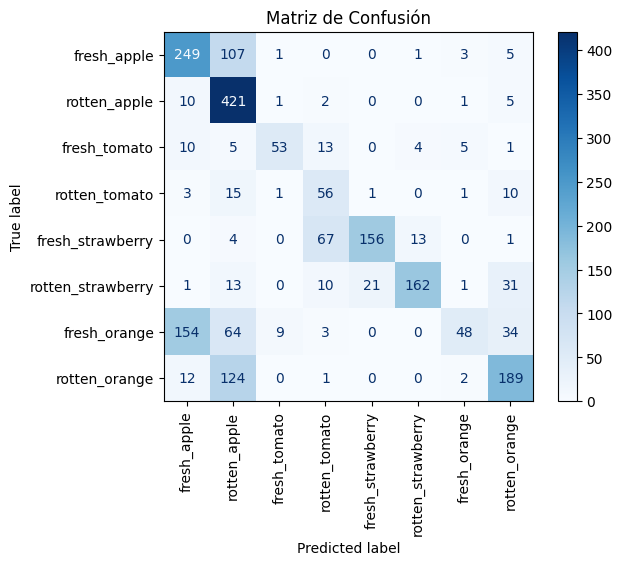

In [23]:
# Predecir etiquetas en el conjunto de prueba
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
ConfusionMatrixDisplay(cm, display_labels=list(label_map.keys())).plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matriz de Confusión")
plt.show()

# Matriz de Confusión del Segundo Modelo CNN

La matriz de confusión presentada a continuación refleja el desempeño del segundo modelo CNN en el conjunto de datos de prueba. Recordemos que este modelo incluyó técnicas de regularización de kernel y Batch Normalization para reducir el sobreajuste observado en el primer modelo.

## Interpretación de la Matriz de Confusión
Cada fila representa las etiquetas verdaderas de cada clase, mientras que cada columna representa las predicciones realizadas por el modelo:
- La diagonal principal (de la esquina superior izquierda a la inferior derecha) contiene los valores de las predicciones correctas para cada clase.
- Los valores fuera de la diagonal representan los errores de clasificación, donde el modelo confundió una clase con otra.

### Observaciones Clave
1. **fresh_apple**:
   - Correctas: 249
   - Errores comunes: Se confunde con "rotten_apple" en 107 instancias.

2. **rotten_apple**:
   - Correctas: 421
   - Errores mínimos en comparación con otras clases, aunque se confunde levemente con "fresh_apple" (10 instancias).

3. **fresh_tomato** y **rotten_tomato**:
   - Ambos presentan algunas confusiones entre sí y con otras clases, aunque la mayoría de sus predicciones son correctas.
   - El modelo parece tener más dificultades para clasificar correctamente "rotten_tomato", con algunas confusiones significativas.

4. **fresh_strawberry** y **rotten_strawberry**:
   - Buen desempeño general, con 156 y 162 instancias clasificadas correctamente, respectivamente.
   - Sin embargo, existen algunas confusiones entre ellas y con otras clases.

5. **fresh_orange** y **rotten_orange**:
   - Notable confusión, especialmente con "fresh_apple" y "rotten_apple", lo que podría indicar que las características visuales de estas clases son similares según el modelo.

### Conclusión
Este segundo modelo muestra una reducción en el sobreajuste en comparación con el primer modelo, aunque todavía enfrenta desafíos en la clasificación precisa de algunas clases, particularmente entre frutas frescas y podridas del mismo tipo (por ejemplo, "fresh_apple" y "rotten_apple"). Para mejorar el desempeño, se podrían explorar:
- **Aumento de datos** para aumentar la variabilidad en las clases más difíciles.
- Ajustes adicionales en la arquitectura o en la cantidad de regularización para mejorar la capacidad de generalización del modelo.

Esta matriz de confusión proporciona una visión detallada de las fortalezas y áreas de mejora del modelo, ayudando a identificar las clases que requieren más atención.


In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2

# Definición del modelo CNN con parámetros en BatchNormalization
model3 = Sequential([
    Conv2D(32, (3, 3), kernel_regularizer=L2(1e-4), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), kernel_regularizer=L2(1e-4), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(momentum=0.99, epsilon=1e-3, axis=-1, center=True, scale=True),
    Conv2D(128, (3, 3), kernel_regularizer=L2(1e-4), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(momentum=0.99, epsilon=1e-3, axis=-1, center=True, scale=True),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Cambiado a 8 clases de salida
])

# Compilar el modelo
model3.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Resumen del modelo
model3.summary()


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,576 (18.42 MB)

 Trainable params: 4,829,192 (18.42 MB)

 Non-trainable params: 384 (1.50 KB)

In [25]:
# Entrenar el modelo
history3 = model3.fit(X_train, y_train_cat, epochs=20, batch_size=32,
                    validation_data=(X_val, y_val_cat))

Epoch 1/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 85s 272ms/step - accuracy: 0.2971 - loss: 4.4566 - val_accuracy: 0.2234 - val_loss: 2.0003
Epoch 2/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 81s 264ms/step - accuracy: 0.3484 - loss: 1.6781 - val_accuracy: 0.4368 - val_loss: 1.4539
Epoch 3/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 80s 263ms/step - accuracy: 0.3474 - loss: 1.6113 - val_accuracy: 0.3971 - val_loss: 1.4499
Epoch 4/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 81s 263ms/step - accuracy: 0.3693 - loss: 1.5171 - val_accuracy: 0.2745 - val_loss: 2.3270
Epoch 5/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 80s 261ms/step - accuracy: 0.3967 - loss: 1.4109 - val_accuracy: 0.3527 - val_loss: 1.8323
Epoch 6/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 80s 261ms/step - accuracy: 0.4583 - loss: 1.3257 - val_accuracy: 0.3809 - val_loss: 1.9412
Epoch 7/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 80s 261ms/step - accuracy: 0.5072 - loss: 1.2012 - val_accuracy: 0.4253 - val_loss: 2.1933
Epoch 8/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 80s 262ms/step - accuracy: 0.5811 - loss: 1

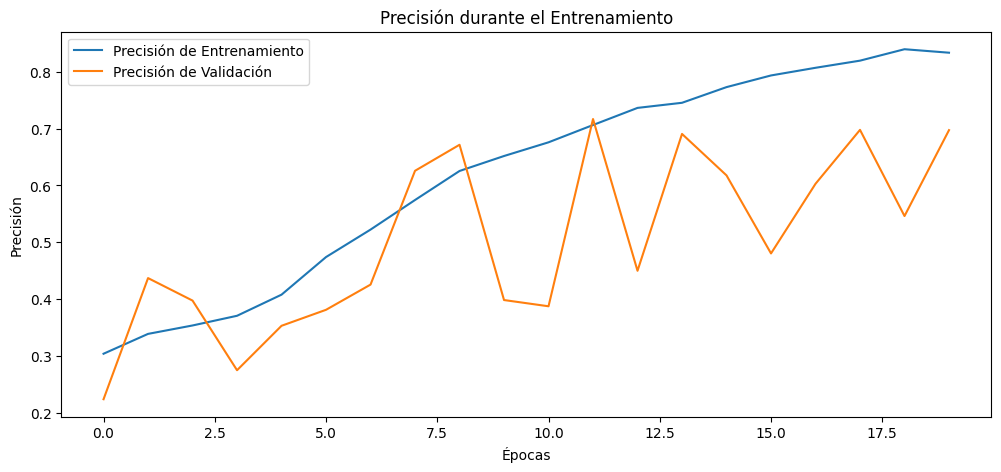

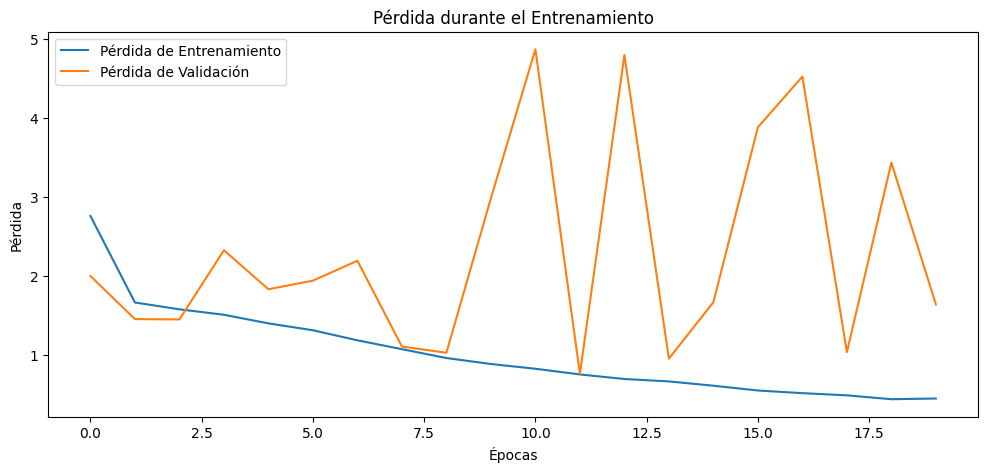

In [26]:
# Gráfica de precisión
plt.figure(figsize=(12, 5))
plt.plot(history3.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history3.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title("Precisión durante el Entrenamiento")
plt.show()

# Gráfica de pérdida
plt.figure(figsize=(12, 5))
plt.plot(history3.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history3.history  ['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title("Pérdida durante el Entrenamiento")
plt.show()

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step


<Figure size 1200x1000 with 0 Axes>

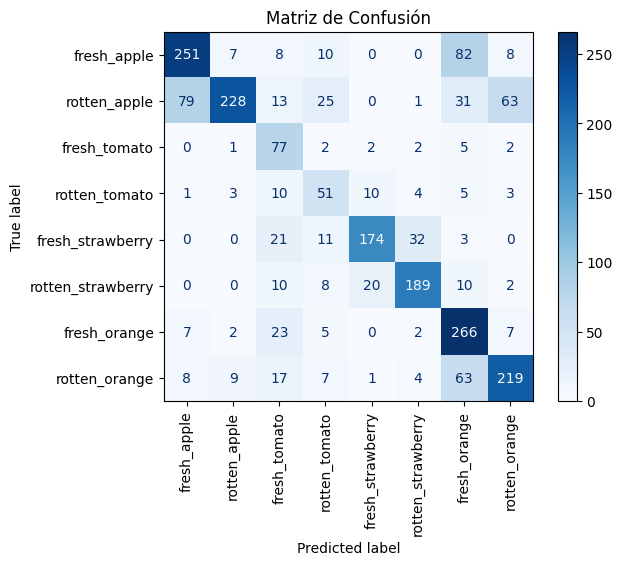

In [27]:
# Predecir etiquetas en el conjunto de prueba
y_pred = model3.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
ConfusionMatrixDisplay(cm, display_labels=list(label_map.keys())).plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matriz de Confusión")
plt.show()

# Tercer Modelo CNN

Se realizó un tercer modelo CNN en el que el único cambio fue la inclusión de parámetros adicionales para las capas de Batch Normalization. Estos parámetros permiten ajustar de manera más precisa la normalización de las activaciones de las capas, lo cual puede mejorar la estabilidad y velocidad de convergencia durante el entrenamiento. La adición de estos parámetros tiene como objetivo optimizar el efecto de Batch Normalization observado en el segundo modelo, con la esperanza de lograr una mayor generalización y reducir aún más el sobreajuste.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Configurar data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Definir el modelo CNN con el mismo diseño, ahora llamado model5
model5 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Cambiado a 8 clases de salida
])

# Compilar el modelo
model5.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model5.summary()

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,808 (18.42 MB)

 Trainable params: 4,828,808 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# Cuarto Modelo CNN con Data Augmentation

Este cuarto modelo CNN utiliza la misma arquitectura que el primer modelo, pero con la adición de técnicas de **data augmentation** para mejorar la capacidad de generalización y reducir el sobreajuste. La estrategia de data augmentation genera nuevas variaciones de las imágenes originales durante el entrenamiento, lo que permite al modelo aprender características más robustas y generalizables.

## Configuración de Data Augmentation
Se configura un generador de datos (`ImageDataGenerator`) con las siguientes transformaciones:
- **Rotación**: rotación aleatoria de hasta 20 grados.
- **Desplazamiento horizontal y vertical** (`width_shift_range` y `height_shift_range`): hasta 20% de la imagen.
- **Cizallamiento** (`shear_range`): distorsión de la imagen hasta un 20%.
- **Zoom** (`zoom_range`): aumento o reducción de hasta un 20%.
- **Inversión horizontal** (`horizontal_flip`): voltea aleatoriamente la imagen de forma horizontal.
- **Fill Mode**: establece el modo de llenado para los píxeles vacíos tras la transformación a "nearest".

Estas transformaciones introducen variabilidad en los datos de entrada, ayudando al modelo a aprender características más diversas y reducir el riesgo de memorizar patrones específicos del conjunto de entrenamiento.

## Arquitectura del Modelo
La arquitectura de este cuarto modelo es idéntica a la del primer modelo:
1. Tres capas convolucionales con activación ReLU y MaxPooling.
2. Una capa de Flatten para transformar las características 2D en un vector 1D.
3. Una capa densa de 128 unidades con activación ReLU, seguida de una capa de Dropout con una tasa de 0.5.
4. Una capa de salida de 8 unidades con activación Softmax para la clasificación de las 8 clases.

## Compilación del Modelo
El modelo se compila utilizando:
- **Optimizador**: Adam.
- **Función de pérdida**: Categorical Crossentropy.
- **Métrica**: Exactitud (accuracy).

El uso de data augmentation en este modelo tiene como objetivo mejorar el rendimiento en el conjunto de validación y reducir el sobreajuste sin modificar la arquitectura original. Esta técnica aumenta la variabilidad en los datos, permitiendo que el modelo generalice mejor y mejore su precisión en datos no vistos.


In [43]:
# Entrenar el modelo con data augmentation
history = model5.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),  # Usamos datagen para augmentación en el flujo de entrenamiento
    epochs=20,
    validation_data=(X_val, y_val_cat)
)



Epoch 1/20


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


306/306 ━━━━━━━━━━━━━━━━━━━━ 77s 247ms/step - accuracy: 0.2413 - loss: 1.8176 - val_accuracy: 0.3933 - val_loss: 1.3865
Epoch 2/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 75s 246ms/step - accuracy: 0.3759 - loss: 1.5027 - val_accuracy: 0.5150 - val_loss: 1.2105
Epoch 3/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 69s 225ms/step - accuracy: 0.4355 - loss: 1.3914 - val_accuracy: 0.5714 - val_loss: 1.1065
Epoch 4/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 68s 222ms/step - accuracy: 0.4561 - loss: 1.3413 - val_accuracy: 0.5871 - val_loss: 1.0550
Epoch 5/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 68s 223ms/step - accuracy: 0.4880 - loss: 1.2659 - val_accuracy: 0.5823 - val_loss: 1.0537
Epoch 6/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 69s 224ms/step - accuracy: 0.5274 - loss: 1.2171 - val_accuracy: 0.6124 - val_loss: 0.9760
Epoch 7/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 68s 223ms/step - accuracy: 0.5421 - loss: 1.1557 - val_accuracy: 0.6406 - val_loss: 0.9366
Epoch 8/20
306/306 ━━━━━━━━━━━━━━━━━━━━ 68s 224ms/step - accuracy: 0.5674 - loss: 1.1156 - val

In [44]:
# Evaluar el modelo
test_loss, test_accuracy = model5.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.8270 - loss: 0.5404
Test accuracy: 81.80%


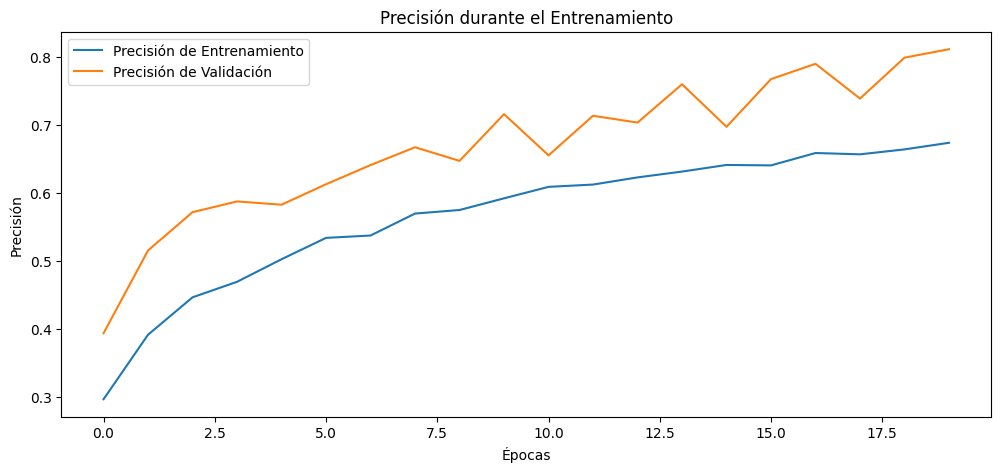

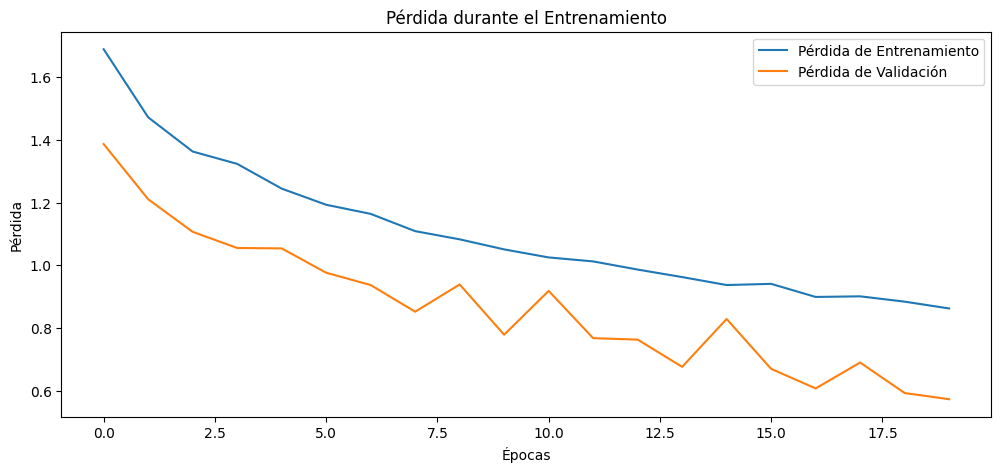

In [45]:
# Gráfica de precisión
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title("Precisión durante el Entrenamiento")
plt.show()

# Gráfica de pérdida
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history  ['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title("Pérdida durante el Entrenamiento")
plt.show()

# Gráficos de Precisión y Pérdida durante el Entrenamiento del Cuarto Modelo con Data Augmentation

Estos gráficos muestran el desempeño del cuarto modelo CNN en términos de precisión y pérdida durante el entrenamiento y la validación. Recordemos que este modelo utiliza la misma arquitectura que el primer modelo, pero incorpora técnicas de **data augmentation** para mejorar la generalización y reducir el sobreajuste.

## Precisión durante el Entrenamiento
- El gráfico superior muestra la **precisión** del modelo en cada época:
  - La curva azul representa la precisión en el conjunto de entrenamiento.
  - La curva naranja representa la precisión en el conjunto de validación.
- En comparación con los modelos anteriores, observamos que la precisión en el conjunto de validación se estabiliza más cerca de la precisión de entrenamiento. Esto sugiere que el data augmentation está ayudando al modelo a generalizar mejor en el conjunto de validación.
- Aunque la precisión del conjunto de entrenamiento es más baja que en el primer modelo, este es un efecto esperado del data augmentation, ya que el modelo se enfrenta a imágenes transformadas y diversas durante el entrenamiento, lo cual reduce el riesgo de sobreajuste.

## Pérdida durante el Entrenamiento
- El gráfico inferior muestra la **pérdida** para el conjunto de entrenamiento y el conjunto de validación en cada época:
  - La curva azul representa la pérdida en el conjunto de entrenamiento.
  - La curva naranja representa la pérdida en el conjunto de validación.
- Observamos que la pérdida en el conjunto de validación sigue una tendencia decreciente y se mantiene relativamente cercana a la pérdida de entrenamiento, lo que indica una mejora en la estabilidad del modelo en datos no vistos.
- La pérdida de entrenamiento es mayor en comparación con los modelos anteriores debido a la dificultad añadida por el data augmentation, lo cual es una señal positiva de que el modelo no está sobreajustándose a los datos de entrenamiento.

## Conclusión
La incorporación de data augmentation en este cuarto modelo parece haber reducido el sobreajuste y mejorado la capacidad de generalización del modelo. La menor precisión y mayor pérdida en el conjunto de entrenamiento, junto con la precisión y pérdida relativamente estables en el conjunto de validación, sugieren que el modelo está aprendiendo características más generalizables en lugar de memorizar patrones específicos. Estos resultados muestran el beneficio de usar data augmentation para mejorar el rendimiento del modelo en datos no vistos.


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step


<Figure size 1200x1000 with 0 Axes>

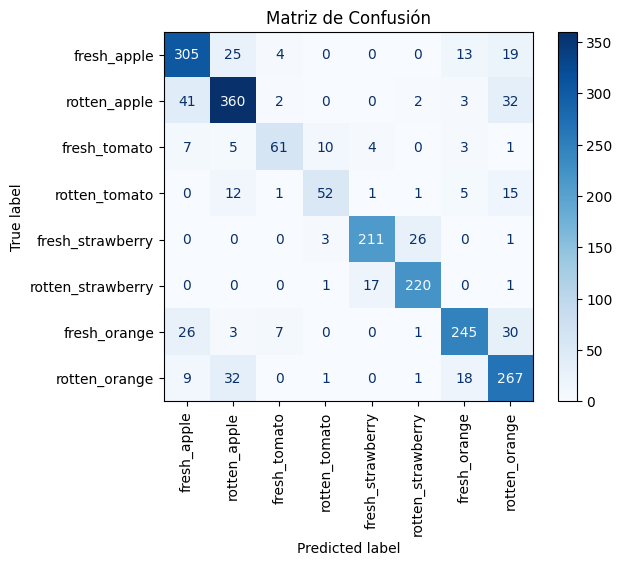

In [46]:
# Predecir etiquetas en el conjunto de prueba
y_pred = model5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
ConfusionMatrixDisplay(cm, display_labels=list(label_map.keys())).plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matriz de Confusión")
plt.show()

# Matriz de Confusión del Cuarto Modelo CNN con Data Augmentation

La matriz de confusión presentada a continuación muestra el desempeño del cuarto modelo CNN en el conjunto de datos de prueba. Este modelo utiliza la misma arquitectura que el primer modelo, pero incorpora **data augmentation** para mejorar la generalización y reducir el sobreajuste.

## Interpretación de la Matriz de Confusión
Cada fila representa las etiquetas verdaderas de cada clase, mientras que cada columna representa las predicciones realizadas por el modelo:
- La diagonal principal (de la esquina superior izquierda a la inferior derecha) contiene los valores de las predicciones correctas para cada clase.
- Los valores fuera de la diagonal representan los errores de clasificación, donde el modelo confundió una clase con otra.

### Observaciones Clave
1. **fresh_apple**:
   - Correctas: 305
   - Errores comunes: Confundido con "rotten_apple" (25 instancias) y "fresh_orange" (13 instancias).

2. **rotten_apple**:
   - Correctas: 360
   - Errores comunes: Confundido con "fresh_apple" (41 instancias) y "rotten_orange" (32 instancias).

3. **fresh_tomato** y **rotten_tomato


In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Configurar data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [48]:

# Definir el modelo CNN con el mismo diseño, ahora llamado model5
model6 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')  # Cambiado a 8 clases de salida
])

# Compilar el modelo
model6.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

model6.summary()

c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,808 (18.42 MB)

 Trainable params: 4,828,808 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# Sexto Modelo CNN

Este sexto modelo CNN utiliza la misma arquitectura que el quinto modelo, pero incorpora un `ImageDataGenerator` con parámetros de aumento de datos (data augmentation) ligeramente diferentes. Al igual que el quinto modelo, este modelo mantiene la misma estructura que el primer modelo, pero introduce modificaciones en las transformaciones de data augmentation para mejorar la generalización y robustez del modelo.

## Cambios en el `ImageDataGenerator`
El generador de datos se configura con variaciones menores en las transformaciones de data augmentation en comparación con el modelo anterior. Estas modificaciones incluyen cambios en:
- **Rango de rotación**: permite rotaciones diferentes.
- **Desplazamientos y zoom**: ligeras variaciones en el rango de desplazamiento horizontal y vertical, así como en el factor de zoom.

Estas alteraciones en el data augmentation tienen como objetivo exponer al modelo a una mayor diversidad de datos, ayudándolo a aprender características más generalizables y reducir el riesgo de sobreajuste.

## Arquitectura del Modelo
La arquitectura de este sexto modelo es idéntica a la de los modelos anteriores y consta de:
1. Tres capas convolucionales con activación ReLU y MaxPooling.
2. Una capa de Flatten para transformar las características 2D en un vector 1D.
3. Una capa densa de 128 unidades con activación ReLU, seguida de una capa de Dropout con una tasa de 0.5.
4. Una capa de salida de 8 unidades con activación Softmax para la clasificación de las 8 clases.

## Compilación del Modelo
El modelo se compila utilizando:
- **Optimizador**: Adam.
- **Función de pérdida**: Categorical Crossentropy.
- **Métrica**: Exactitud (accuracy).

Este sexto modelo permite evaluar si una ligera variación en los parámetros de data augmentation puede mejorar la capacidad de generalización del modelo en comparación con el quinto modelo. La idea es observar si estas modificaciones logran un mejor balance entre la precisión en el entrenamiento y la validación.


In [49]:
# Entrenar el modelo con data augmentation
history = model6.fit(
    datagen.flow(X_train, y_train_cat, batch_size=32),  # Usamos datagen para augmentación en el flujo de entrenamiento
    epochs=30,
    validation_data=(X_val, y_val_cat)
)


Epoch 1/30


c:\Users\sebas\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


306/306 ━━━━━━━━━━━━━━━━━━━━ 71s 228ms/step - accuracy: 0.2520 - loss: 1.8344 - val_accuracy: 0.4387 - val_loss: 1.3824
Epoch 2/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - accuracy: 0.3904 - loss: 1.4716 - val_accuracy: 0.5088 - val_loss: 1.2155
Epoch 3/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - accuracy: 0.4657 - loss: 1.3262 - val_accuracy: 0.4974 - val_loss: 1.2233
Epoch 4/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 73s 238ms/step - accuracy: 0.5062 - loss: 1.2294 - val_accuracy: 0.6115 - val_loss: 1.0236
Epoch 5/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - accuracy: 0.5348 - loss: 1.1660 - val_accuracy: 0.6492 - val_loss: 0.9283
Epoch 6/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - accuracy: 0.5766 - loss: 1.0982 - val_accuracy: 0.6458 - val_loss: 0.9241
Epoch 7/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 67s 218ms/step - accuracy: 0.5975 - loss: 1.0517 - val_accuracy: 0.6850 - val_loss: 0.8946
Epoch 8/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 66s 216ms/step - accuracy: 0.6018 - loss: 1.0206 - val

In [50]:
# Evaluar el modelo
test_loss, test_accuracy = model6.evaluate(X_test, y_test_cat)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.8595 - loss: 0.4161
Test accuracy: 84.84%


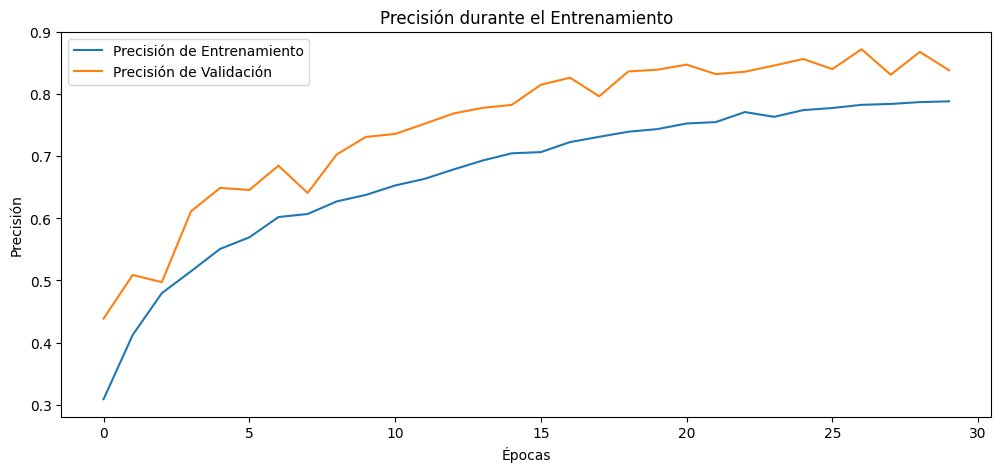

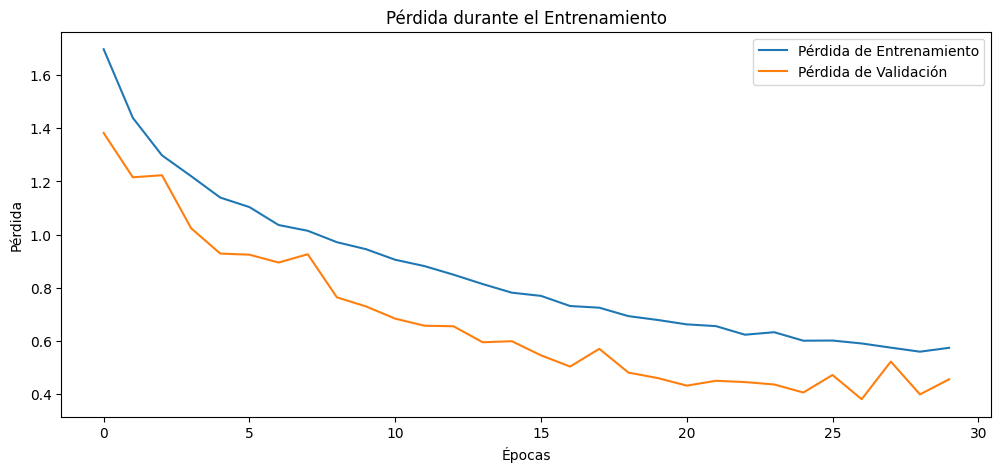

In [51]:
# Gráfica de precisión
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title("Precisión durante el Entrenamiento")
plt.show()

# Gráfica de pérdida
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history  ['val_loss'], label='Pérdida de Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title("Pérdida durante el Entrenamiento")
plt.show()

# Gráficos de Precisión y Pérdida durante el Entrenamiento del Sexto Modelo con Data Augmentation Ajustado

Estos gráficos muestran el desempeño del sexto modelo CNN en términos de precisión y pérdida durante el entrenamiento y la validación. Este modelo utiliza la misma arquitectura que el quinto modelo, pero con un `ImageDataGenerator` que aplica data augmentation con parámetros ligeramente diferentes.

## Precisión durante el Entrenamiento
- El gráfico superior muestra la **precisión** del modelo en cada época:
  - La curva azul representa la precisión en el conjunto de entrenamiento.
  - La curva naranja representa la precisión en el conjunto de validación.
- Se observa que la precisión en el conjunto de validación se mantiene consistentemente más alta que en el conjunto de entrenamiento, alcanzando valores cercanos a 0.8 en las últimas épocas. Esto indica que el modelo está generalizando bien en el conjunto de validación.
- La precisión en el conjunto de entrenamiento aumenta de manera gradual, lo cual es esperado debido al efecto del data augmentation, que introduce variabilidad en los datos y hace que el modelo aprenda características más generalizables en lugar de memorizar patrones específicos.

## Pérdida durante el Entrenamiento
- El gráfico inferior muestra la **pérdida** para el conjunto de entrenamiento y el de validación en cada época:
  - La curva azul representa la pérdida en el conjunto de entrenamiento.
  - La curva naranja representa la pérdida en el conjunto de validación.
- La pérdida en el conjunto de validación disminuye de manera constante y se mantiene más baja que la pérdida de entrenamiento en la mayoría de las épocas, lo que sugiere que el modelo no está sobreajustándose y se desempeña bien en datos no vistos.
- La disminución constante en ambas pérdidas refleja una buena convergencia del modelo, indicando que el ajuste del `ImageDataGenerator` está ayudando a mejorar la generalización sin comprometer la precisión del modelo.

## Conclusión
El ajuste en los parámetros de data augmentation en este sexto modelo parece haber beneficiado la capacidad de generalización del modelo, logrando una precisión de validación superior y una pérdida más baja en comparación con el conjunto de entrenamiento. Esto sugiere que el modelo está aprendiendo de manera más robusta y que los ajustes en el data augmentation han sido efectivos para mejorar el rendimiento en el conjunto de validación sin incurrir en sobreajuste.


66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step


<Figure size 1200x1000 with 0 Axes>

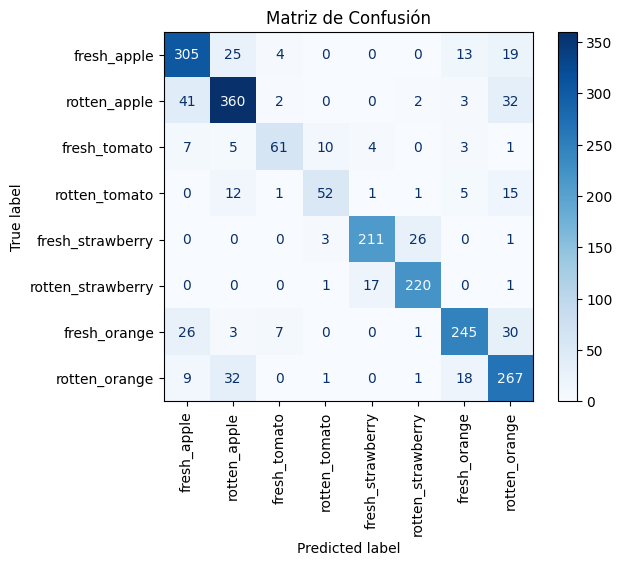

In [52]:
# Predecir etiquetas en el conjunto de prueba
y_pred = model5.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Crear la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 10))
ConfusionMatrixDisplay(cm, display_labels=list(label_map.keys())).plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Matriz de Confusión")
plt.show()

# Matriz de Confusión del Sexto Modelo CNN con Data Augmentation Ajustado

La matriz de confusión presentada a continuación muestra el desempeño del sexto modelo CNN en el conjunto de datos de prueba. Este modelo utiliza la misma arquitectura que el quinto modelo, pero con parámetros de **data augmentation** ligeramente ajustados para mejorar la capacidad de generalización.

## Interpretación de la Matriz de Confusión
Cada fila representa las etiquetas verdaderas de cada clase, mientras que cada columna representa las predicciones realizadas por el modelo:
- La diagonal principal (de la esquina superior izquierda a la inferior derecha) contiene los valores de las predicciones correctas para cada clase.
- Los valores fuera de la diagonal representan los errores de clasificación, donde el modelo confundió una clase con otra.

### Observaciones Clave
1. **fresh_apple**:
   - Correctas: 305
   - Errores comunes: Confundido con "rotten_apple" (25 instancias) y "fresh_orange" (13 instancias).

2. **rotten_apple**:
   - Correctas: 360
   - Errores comunes: Confundido con "fresh_apple" (41 instancias) y "rotten_orange" (32 instancias).

3. **fresh_tomato** y **rotten_tomato**:
   - Ambos presentan algunas confusiones entre sí y con otras clases, aunque la mayoría de sus predicciones son correctas.
   - "rotten_tomato" tiene más dificultades de clasificación, con algunas confusiones notables.

4. **fresh_strawberry** y **rotten_strawberry**:
   - Buen desempeño en general, con 211 y 220 instancias clasificadas correctamente, respectivamente.
   - Existen algunas confusiones menores entre estas clases y otras, pero el modelo logra una buena precisión en estas categorías.

5. **fresh_orange** y **rotten_orange**:
   - Buen desempeño, aunque existen algunas confusiones, especialmente con "fresh_apple" y "rotten_apple".

### Conclusión
El sexto modelo muestra una mejora en la capacidad de generalización, reflejada en una matriz de confusión que indica una mayor precisión en varias clases clave. Las ligeras modificaciones en el data augmentation parecen haber ayudado a reducir el sobreajuste, permitiendo que el modelo aprenda características más robustas y generalizables. Aunque persisten algunas confusiones, especialmente entre frutas frescas y podridas del mismo tipo, el desempeño general es sólido, demostrando la efectividad de los ajustes de data augmentation.


Guardar el Modelo 

In [53]:
# Guardar el modelo
model6.save("fruit_classification_model.h5")


# Conclusión y Próximos Pasos

El sexto modelo CNN mostró un buen desempeño en términos de precisión y pérdida en el conjunto de validación, con una matriz de confusión que refleja una clasificación adecuada en la mayoría de las categorías. Las ligeras modificaciones en el data augmentation ayudaron a mejorar la capacidad de generalización del modelo, reduciendo el sobreajuste y aumentando la estabilidad en datos no vistos.

## Próximos Pasos para Mejorar el Modelo
Aunque este sexto modelo ha alcanzado un nivel aceptable de precisión, se propone realizar mejoras adicionales para incrementar aún más el accuracy. Algunas de las estrategias a considerar son:
- **Ajustar aún más los parámetros de data augmentation**: Introducir variaciones adicionales en el data augmentation puede ayudar a exponer al modelo a una gama más amplia de ejemplos, fortaleciendo su capacidad para identificar correctamente diferentes clases.
- **Optimizar la arquitectura del modelo**: Probar con una mayor o menor cantidad de filtros en las capas convolucionales o modificar la profundidad de la red puede ayudar a capturar características más relevantes y específicas de cada clase.
- **Ajustar la tasa de aprendizaje o probar otros optimizadores**: Realizar un ajuste fino en la tasa de aprendizaje o experimentar con optimizadores diferentes, como RMSprop o SGD con momentum, podría mejorar la convergencia del modelo y, por ende, su precisión.

Implementar estas mejoras permitirá refinar aún más el rendimiento del modelo, con el objetivo de alcanzar una precisión superior en el conjunto de validación y en datos de prueba. Con estas optimizaciones, se espera que el modelo sea capaz de obtener un accuracy más alto y una generalización aún más robusta.
